# End-To-End Handwriting Recognition

**Requerements**

In [0]:
import urllib.request
import cv2
import importlib
import random
random.seed(123)
import gluonnlp as nlp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
import ocr.utils.denoiser_utils
from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
import ocr.utils.beam_search
importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator
importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch
from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding
from ocr.utils.sclite_helper import ScliteHelper
from medacy.ner.model import Model

In [0]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

## Dataset creation
Obtain medical prescription image from url and plot the results.

In [0]:
random.seed(1)

In [0]:
images = []

resp = urllib.request.urlopen("https://i.ibb.co/gV8yRgD/Untitled-design-6.jpg")
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)

images.append(image)

print(image)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


### Paragraph segmentation

Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component.

In [0]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [0]:
paragraph_segmentation_net.hybridize()

(-0.5, 799.5, 799.5, -0.5)

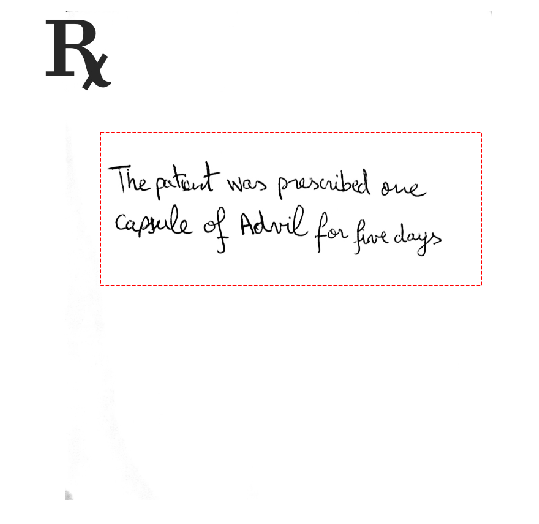

In [0]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(figsize=(16, 9))
resized_image = paragraph_segmentation_transform(image, form_size)
bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
bb_predicted = bb_predicted[0].asnumpy()
bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                       expand_bb_scale_y=0.03)
predicted_bbs.append(bb_predicted)
    
axs.imshow(image, cmap='Greys_r')

(x, y, w, h) = bb_predicted
image_h, image_w = image.shape[-2:]
(x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
axs.add_patch(rect)
axs.axis('off')

## Image Processing

Crop the handwriting component out of the original IAM form.



(-0.5, 699.5, 699.5, -0.5)

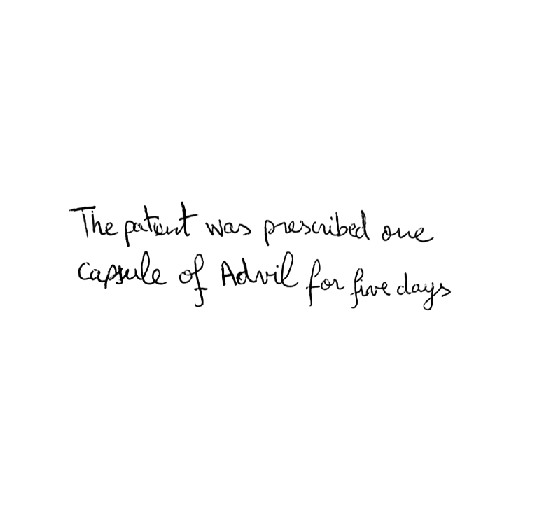

In [0]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(figsize=(16, 9))

paragraph_segmented_images = []

bb = predicted_bbs[0]
image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
paragraph_segmented_images.append(image)

axs.imshow(image, cmap='Greys_r')
axs.axis('off')

## Line/word segmentation

Given a form with only handwritten text, predict a bounding box for each word.

In [0]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

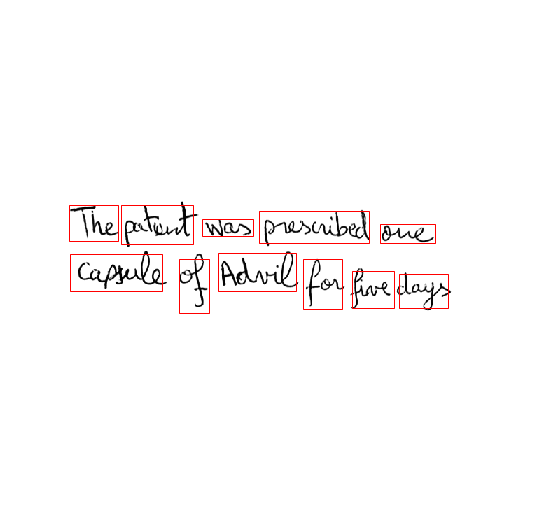

In [0]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(figsize=(16, 9))

predicted_words_bbs_array = []

predicted_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_images[0], min_c, overlap_thres, topk, ctx)

predicted_words_bbs_array.append(predicted_bb)

axs.imshow(paragraph_segmented_images[0], cmap='Greys_r')
for j in range(predicted_bb.shape[0]):     
    (x, y, w, h) = predicted_bb[j]
    image_h, image_w = paragraph_segmented_images[0].shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs.add_patch(rect)
    axs.axis('off')

### Word to line image processing
Algorithm to sort then group all words within a line together.

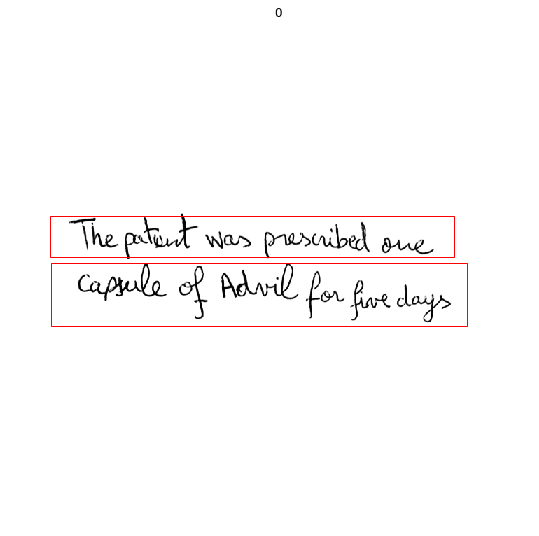

In [0]:
line_images_array = []

fig, axs = plt.subplots(figsize=(16, 9))

axs.imshow(paragraph_segmented_images[0], cmap='Greys_r')
axs.axis('off')
axs.set_title("{}".format(0))

predicted_bbs = predicted_words_bbs_array[0]
line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
line_images = crop_line_images(paragraph_segmented_images[0], line_bbs)
line_images_array.append(line_images)

for line_bb in line_bbs:
    (x, y, w, h) = line_bb
    image_h, image_w = paragraph_segmented_images[0].shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs.add_patch(rect)

## Handwriting recognition
Given each line of text, predict a string of the handwritten text.

In [0]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [0]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Character Probalities to Text

In [0]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [0]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

## Denoising the text output

We use a seq2seq denoiser to translate noisy input to better output

In [0]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [0]:
denoiser.hybridize(static_alloc=True)

We use a language model in order to rank the propositions from the denoiser

In [0]:
ctx_nlp = ctx
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

We use beam search to sample the output of the denoiser

In [0]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [0]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)

In [0]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)
    return output.strip()

In [0]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
# print(sentence)
# print("Choice")
# print(generator.generate_sequences(inputs, states, sentence))

## Qualitative Result

- [AM] Arg Max CTC Decoding
- [BS] Beam Search CTC Decoding
- [D ] Adding Text Denoiser

In [0]:
model = Model.load_external('medacy_model_clinical_notes')

for i, form_character_probs in enumerate(character_probs):
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        annotationAM = model.predict(decoded_line_am)
        print(annotationAM)
#         decoded_line_bs = get_beam_search(line_character_probs)
#         decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
#         print("[D ]",decoded_line_denoiser)
#         annotationD = model.predict(decoded_line_denoiser)
#         print(annotationD)

[AM] The patient was prescribed one
{'entities': {}, 'relations': []}
[AM] capsule of Advil for fuedays
{'entities': {'T1': ('Form', 0, 7, 'capsule'), 'T2': ('Drug', 11, 16, 'Advil')}, 'relations': []}
